# pip installs

In [1]:
!pip install datasets
!pip install wordcloud
!pip install gensim nltk scikit-learn tqdm
# Optional (for training/using GloVe locally):
!pip install glove-python-binary
# If you prefer pretrained GloVe vectors (recommended), download them manually from the GloVe project page:
# https://nlp.stanford.edu/projects/glove/



ERROR: Could not find a version that satisfies the requirement glove-python-binary (from versions: none)
ERROR: No matching distribution found for glove-python-binary


# imports


In [ ]:
#title
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt
import re
import string
from matplotlib.patches import Patch
import nltk
from nltk import pos_tag, word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud




# downlodes

In [3]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger_eng")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# EDA 1

In [4]:
#loading data
dataset = load_dataset("artem9k/ai-text-detection-pile")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['source', 'id', 'text'],
        num_rows: 1392522
    })
})


In [5]:

data = dataset["train"].to_pandas()
data.head()

,source,id,text
0,human,0,12 Years a Slave: An Analysis of the Film Essa...
1,human,1,20+ Social Media Post Ideas to Radically Simpl...
2,human,2,2022 Russian Invasion of Ukraine in Global Med...
3,human,3,533 U.S. 27 (2001) Kyllo v. United States: The...
4,human,4,A Charles Schwab Corporation Case Essay\n\nCha...


In [6]:
#null
print(data.isnull().sum())

source    0
id        0
text      0
dtype: int64


source
human    1028146
ai        364376
Name: count, dtype: int64


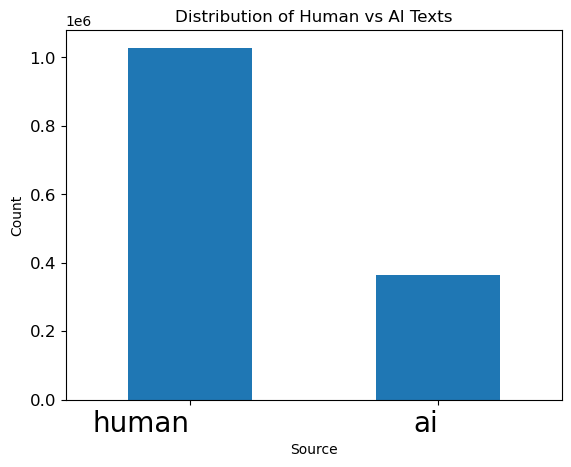

In [7]:
print(data["source"].value_counts())
data["source"].value_counts().plot(kind="bar")
plt.title("Distribution of Human vs AI Texts")
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(fontsize=20, rotation=0, ha="right")                # Bigger x-ticks, rotated for readability
plt.yticks(fontsize=12)    
plt.show()

# data engineering 1

In [8]:
#balancing data to 300,000 rows each

human_df = data[data["source"] == "human"].sample(n=500000, random_state=42)
ai_df    = data[data["source"] == "ai"].sample(n=300000, random_state=42)


df = pd.concat([human_df, ai_df]).reset_index(drop=True)

print(df["source"].value_counts())

source
human    500000
ai       300000
Name: count, dtype: int64


# EDA 2

In [9]:
#text length mean 

df["text_length"] = df["text"].str.len()

print("text length by source: ",df.groupby("source")["text_length"].mean())

text length by source:  source
ai       2219.645987
human    2457.011402
Name: text_length, dtype: float64


In [10]:
print("text length by source: ",df.groupby("source")["text_length"].median())

text length by source:  source
ai       1771.0
human     996.0
Name: text_length, dtype: float64


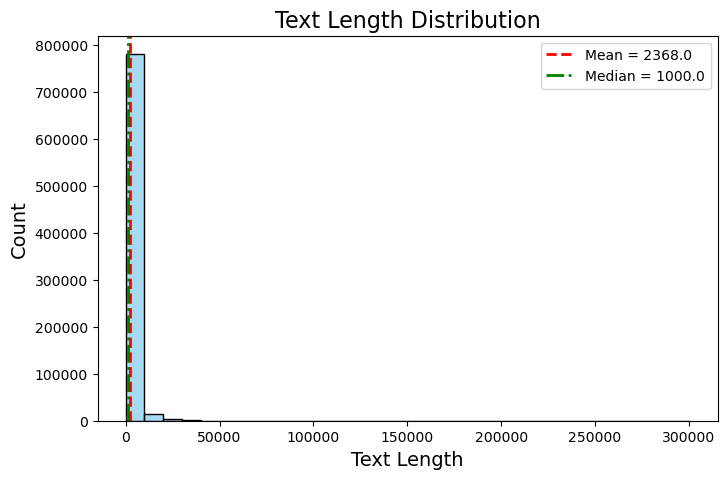

In [11]:


plt.figure(figsize=(8,5))

# Plot a single histogram (no separation by source)
sns.histplot(df["text_length"], bins=30, kde=False, color="skyblue")

# Calculate stats
mean_val = df["text_length"].mean()
median_val = df["text_length"].median()

# Add lines
plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.1f}")
plt.axvline(median_val, color="green", linestyle="-.", linewidth=2, label=f"Median = {median_val:.1f}")

# Titles & labels
plt.title("Text Length Distribution", fontsize=16)
plt.xlabel("Text Length", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend()

plt.show()


In [12]:
# counting sentences

def count_sentences(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    # Split by ., !, ? followed by space or end of string
    sentences = re.split(r'[.!?]+(?:\s|$)', text.strip())
    # Remove empty strings
    sentences = [s for s in sentences if s]
    return len(sentences)

df["sentence_count"] = df["text"].apply(count_sentences)

In [13]:
print(df.groupby("source")["sentence_count"].mean())       # average sentences


source
ai       17.901023
human    24.897236
Name: sentence_count, dtype: float64


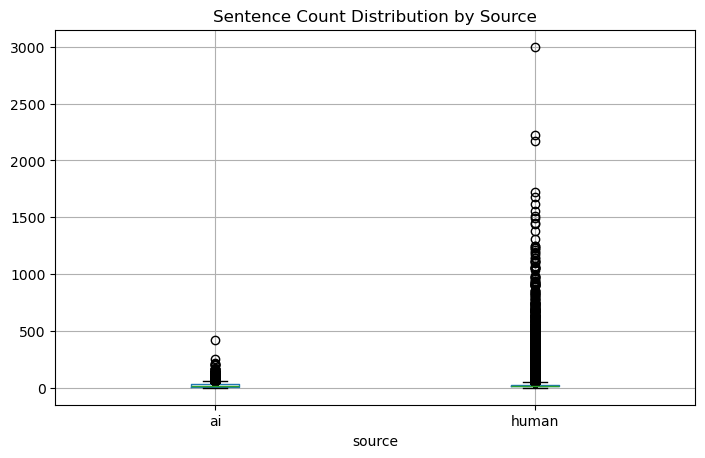

In [14]:
df.boxplot(column="sentence_count", by="source", figsize=(8,5))
plt.title("Sentence Count Distribution by Source")
plt.suptitle("")
plt.show()

In [15]:
def count_words(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    return len(text.split())

def avg_words_per_sentence(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    # Split into sentences
    sentences = re.split(r'[.!?]+(?:\s|$)', text.strip())
    sentences = [s for s in sentences if s.strip()]
    if not sentences:
        return 0
    # Count words in each sentence
    word_counts = [len(s.split()) for s in sentences]
    return sum(word_counts) / len(word_counts)

df["word_count"] = df["text"].apply(count_words)
df["avg_words_per_sentence"] = df["text"].apply(avg_words_per_sentence)


        word_count  avg_words_per_sentence
source                                    
ai      386.738653               23.392167
human   405.118214               17.566498


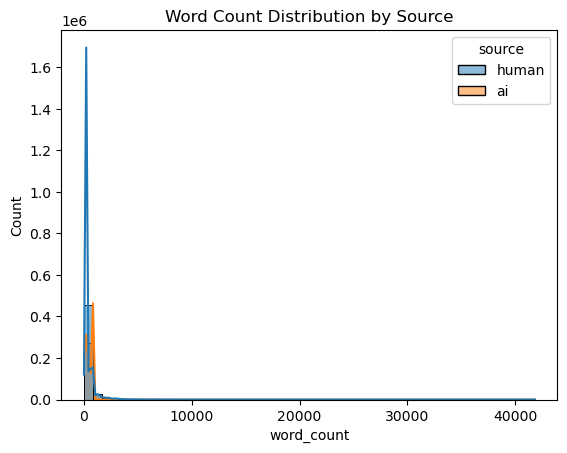

In [16]:
print(df.groupby("source")[["word_count", "avg_words_per_sentence"]].mean())
sns.histplot(data=df, x="word_count", hue="source", kde=True, bins=50)
plt.title("Word Count Distribution by Source")
plt.show()

In [17]:
punctuations = string.punctuation  # !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

# Count occurrences of each punctuation in every text
for p in punctuations:
    df[f"count_{p}"] = df["text"].str.count(re.escape(p))

In [18]:
punct_summary = df.groupby("source")[[col for col in df.columns if col.startswith("count_")]].sum().T
punct_summary.columns = ["AI", "Human"] if "ai" in punct_summary.columns else punct_summary.columns
print(punct_summary)

              AI     Human
count_!    96275    313159
count_"  2049144    866677
count_#    21826     37229
count_$   117155    108328
count_%    47173    114948
count_&    24074    230407
count_'  2262153   3457076
count_(   410936   1313299
count_)   425297   1320245
count_*    19702    475409
count_+    20048     40980
count_,  5546386  10862985
count_-  1117269   2004292
count_.  5896752  13246497
count_/   193551    305179
count_:   449305    809063
count_;    84820    249945
count_<    14818     16461
count_=    36690     73914
count_>    22284     35592
count_?   206910    568016
count_@    18400     22277
count_[    68904     72659
count_\     4636      6836
count_]    67547     73054
count_^      800     10039
count__    61784    177666
count_`     1558   1404285
count_{     8643     12292
count_|    13480     17815
count_}     8302     11802
count_~     3603     14607


In [19]:
punct_avg = df.groupby("source")[[col for col in df.columns if col.startswith("count_")]].mean().T
print(punct_avg)

source          ai      human
count_!   0.320917   0.626318
count_"   6.830480   1.733354
count_#   0.072753   0.074458
count_$   0.390517   0.216656
count_%   0.157243   0.229896
count_&   0.080247   0.460814
count_'   7.540510   6.914152
count_(   1.369787   2.626598
count_)   1.417657   2.640490
count_*   0.065673   0.950818
count_+   0.066827   0.081960
count_,  18.487953  21.725970
count_-   3.724230   4.008584
count_.  19.655840  26.492994
count_/   0.645170   0.610358
count_:   1.497683   1.618126
count_;   0.282733   0.499890
count_<   0.049393   0.032922
count_=   0.122300   0.147828
count_>   0.074280   0.071184
count_?   0.689700   1.136032
count_@   0.061333   0.044554
count_[   0.229680   0.145318
count_\   0.015453   0.013672
count_]   0.225157   0.146108
count_^   0.002667   0.020078
count__   0.205947   0.355332
count_`   0.005193   2.808570
count_{   0.028810   0.024584
count_|   0.044933   0.035630
count_}   0.027673   0.023604
count_~   0.012010   0.029214


In [20]:
df.head()

,source,id,text,text_length,sentence_count,word_count,avg_words_per_sentence,count_!,"count_""",count_#,...,count_[,count_\,count_],count_^,count__,count_`,count_{,count_|,count_},count_~
0,human,255674,From Trailville\n\nUpper Des Plaines River Can...,4708,38,782,20.578947,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,human,72144,Coca-Cola Company’s Performance Measurement Es...,2105,20,318,15.900000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,human,829552,"I can't stop it, you won't like it, you should...",1000,13,184,14.153846,3,0,0,...,0,0,0,0,0,14,0,0,0,0
3,human,332556,"American Sniper, the Clint Eastwood movie abou...",924,9,161,17.888889,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,human,999435,eating them.'' His jaw was clenched so tight t...,992,12,185,15.416667,0,0,0,...,0,0,0,0,0,6,0,0,0,0


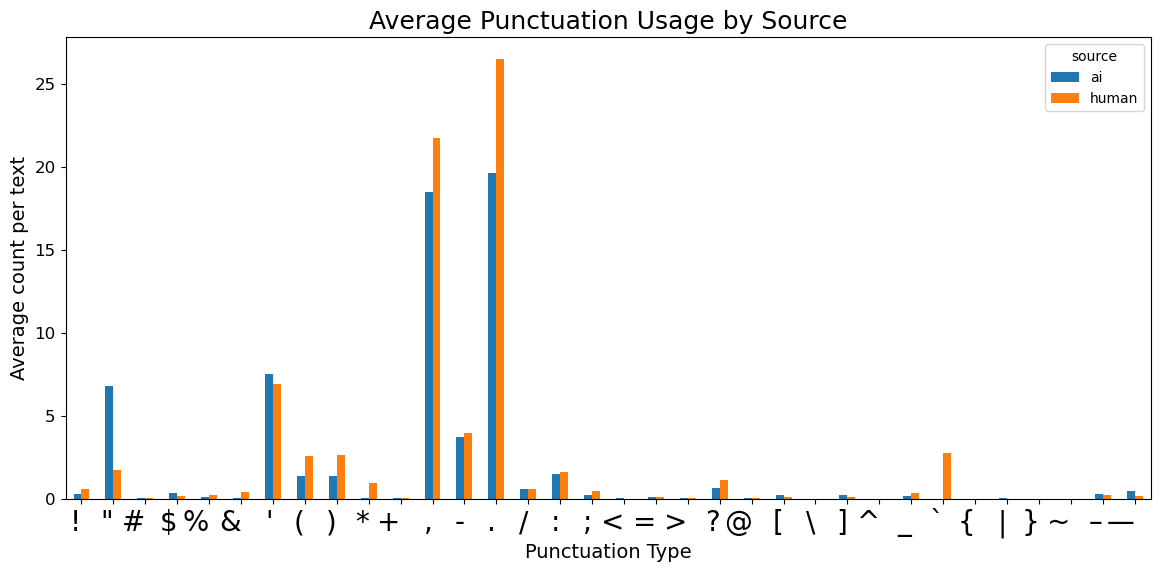

In [21]:
import string
import re
import matplotlib.pyplot as plt

# Define punctuation characters (add em dash and en dash)
punctuations = string.punctuation + "–—"  # en dash (–) and em dash (—)

# Count occurrences of each punctuation in every text
for p in punctuations:
    # Create safe column names by replacing unusual symbols with readable names
    safe_p = p
    if p == "–":
        safe_p = "endash"
    elif p == "—":
        safe_p = "emdash"
    df[f"count_{safe_p}"] = df["text"].str.count(re.escape(p))

# Compute averages by source
punct_avg = (
    df.groupby("source")[
        [col for col in df.columns if col.startswith("count_")]
    ]
    .mean()
    .T
)
punct_avg.index = (
    punct_avg.index.str.replace("count_", "", regex=False)
    .str.replace("endash", "–", regex=False)
    .str.replace("emdash", "—", regex=False)
)

# Plot
punct_avg.plot(kind="bar", figsize=(14, 6))

plt.title("Average Punctuation Usage by Source", fontsize=18)
plt.ylabel("Average count per text", fontsize=14)
plt.xlabel("Punctuation Type", fontsize=14)
plt.xticks(fontsize=20, rotation=0, ha="right")
plt.yticks(fontsize=12)

plt.show()


In [22]:
df["punct_total"] = df["text"].apply(lambda x: len(re.findall(rf"[{re.escape(string.punctuation)}]", str(x))))
avg_punct = df.groupby("source")["punct_total"].mean()
print(avg_punct)

source
ai       64.400750
human    76.546066
Name: punct_total, dtype: float64


In [23]:
df["unique_ratio"] = df["text"].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)
df.head()

,source,id,text,text_length,sentence_count,word_count,avg_words_per_sentence,count_!,"count_""",count_#,...,count__,count_`,count_{,count_|,count_},count_~,count_endash,count_emdash,punct_total,unique_ratio
0,human,255674,From Trailville\n\nUpper Des Plaines River Can...,4708,38,782,20.578947,0,2,0,...,0,0,0,0,0,0,0,0,121,0.466752
1,human,72144,Coca-Cola Company’s Performance Measurement Es...,2105,20,318,15.900000,0,0,0,...,0,0,0,0,0,0,0,0,41,0.591195
2,human,829552,"I can't stop it, you won't like it, you should...",1000,13,184,14.153846,3,0,0,...,0,14,0,0,0,0,0,0,77,0.728261
3,human,332556,"American Sniper, the Clint Eastwood movie abou...",924,9,161,17.888889,0,0,0,...,0,0,0,0,0,0,0,0,22,0.720497
4,human,999435,eating them.'' His jaw was clenched so tight t...,992,12,185,15.416667,0,0,0,...,0,6,0,0,0,0,0,0,36,0.718919


In [24]:
avg_unique_ratio = df.groupby("source")["unique_ratio"].mean()
print(avg_unique_ratio)

source
ai       0.595630
human    0.650203
Name: unique_ratio, dtype: float64


<Axes: xlabel='source', ylabel='unique_ratio'>

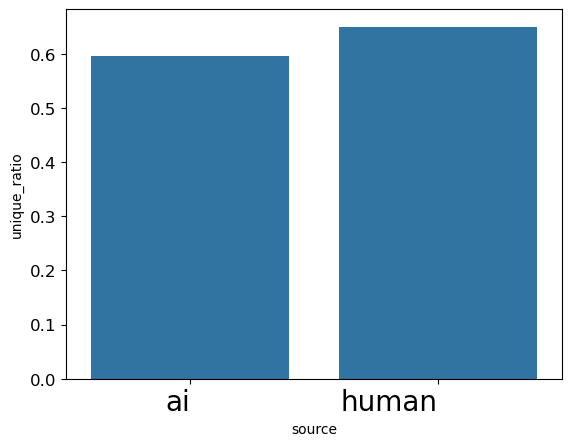

In [25]:
plt.xticks(fontsize=20, rotation=0, ha="right")                # Bigger x-ticks, rotated for readability
plt.yticks(fontsize=12)    
sns.barplot(data=avg_unique_ratio)

# data engineering 2

In [26]:
df.head()

,source,id,text,text_length,sentence_count,word_count,avg_words_per_sentence,count_!,"count_""",count_#,...,count__,count_`,count_{,count_|,count_},count_~,count_endash,count_emdash,punct_total,unique_ratio
0,human,255674,From Trailville\n\nUpper Des Plaines River Can...,4708,38,782,20.578947,0,2,0,...,0,0,0,0,0,0,0,0,121,0.466752
1,human,72144,Coca-Cola Company’s Performance Measurement Es...,2105,20,318,15.900000,0,0,0,...,0,0,0,0,0,0,0,0,41,0.591195
2,human,829552,"I can't stop it, you won't like it, you should...",1000,13,184,14.153846,3,0,0,...,0,14,0,0,0,0,0,0,77,0.728261
3,human,332556,"American Sniper, the Clint Eastwood movie abou...",924,9,161,17.888889,0,0,0,...,0,0,0,0,0,0,0,0,22,0.720497
4,human,999435,eating them.'' His jaw was clenched so tight t...,992,12,185,15.416667,0,0,0,...,0,6,0,0,0,0,0,0,36,0.718919


In [27]:
human_df = data[data["source"] == "human"].sample(n=900000, random_state=42)
ai_df    = data[data["source"] == "ai"].sample(n=300000, random_state=42)


df = pd.concat([human_df, ai_df]).reset_index(drop=True)

print(df["source"].value_counts())

source
human    900000
ai       300000
Name: count, dtype: int64


In [28]:
df["text_length"] = df["text"].str.len()

print("text length by source: ",df.groupby("source")["text_length"].mean())

text length by source:  source
ai       2219.645987
human    2467.671636
Name: text_length, dtype: float64


In [29]:
df_small = df.loc[df['text_length']<700]

In [30]:
len(df_small)

159480

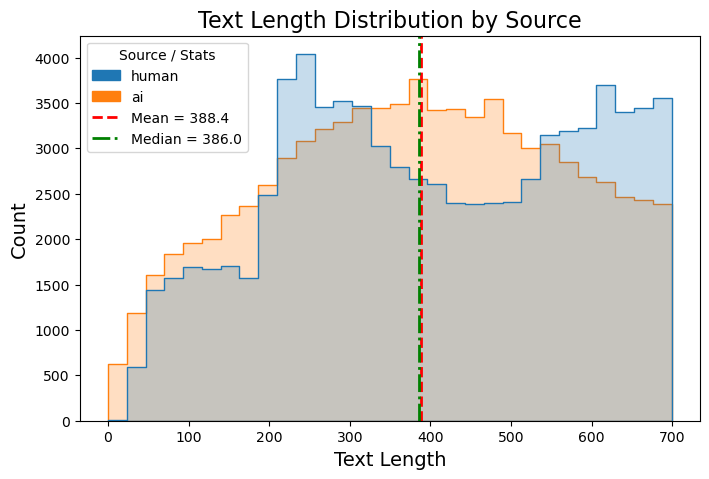

In [31]:

plt.figure(figsize=(8,5))

# Plot histogram
ax = sns.histplot(
    data=df_small,
    x="text_length",
    hue="source",
    bins=30,
    kde=False,
    element="step",   # step outline style
    stat="count"
)

# Calculate stats
mean_val = df_small["text_length"].mean()
median_val = df_small["text_length"].median()

# Add mean/median lines
line_mean = plt.axvline(mean_val, color="red", linestyle="--", linewidth=2,)
line_median = plt.axvline(median_val, color="green", linestyle="-.", linewidth=2)

# --- Build legend manually ---
# Get seaborn's default palette mapping
palette = sns.color_palette(n_colors=df_small["source"].nunique())
sources = df_small["source"].unique()

# Make colored patches for AI/Human
handles = [Patch(facecolor=palette[i], edgecolor=palette[i], label=s) for i, s in enumerate(sources)]

# Add mean/median lines
handles += [line_mean, line_median]
labels = list(sources) + [f"Mean = {mean_val:.1f}", f"Median = {median_val:.1f}"]

plt.legend(handles, labels, title="Source / Stats")

# Titles & labels
plt.title("Text Length Distribution by Source", fontsize=16)
plt.xlabel("Text Length", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.show()


source
ai       81495
human    77985
Name: count, dtype: int64


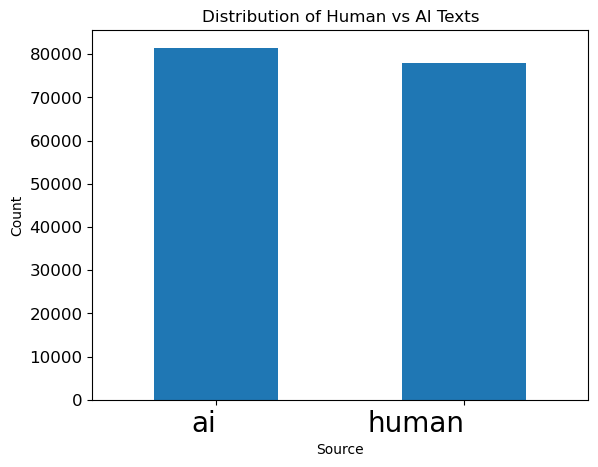

In [32]:
print(df_small["source"].value_counts())
df_small["source"].value_counts().plot(kind="bar")
plt.title("Distribution of Human vs AI Texts")
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(fontsize=20, rotation=0, ha="right")                # Bigger x-ticks, rotated for readability
plt.yticks(fontsize=12)    
plt.show()

In [33]:
df_small.to_csv("df_small.csv", index=False)


# creation of small_df

In [65]:
df_small = pd.read_csv("df_small.csv")


# EDA of small DF

In [35]:
df_small.head()

,source,id,text,text_length
0,human,307353,Our founders are experienced tech industry pro...,333
1,human,281747,William W. Campbell Lippincott Williams & Wilk...,678
2,human,418560,"Bagpipes ( and bugles , also used in such fune...",643
3,human,727582,"I finished it in one binge read, and I think i...",549
4,human,427526,The longer the blonder the hair the more press .,48


In [36]:
df_small = df_small[["source", "text"]]
df_small.head()

,source,text
0,human,Our founders are experienced tech industry pro...
1,human,William W. Campbell Lippincott Williams & Wilk...
2,human,"Bagpipes ( and bugles , also used in such fune..."
3,human,"I finished it in one binge read, and I think i..."
4,human,The longer the blonder the hair the more press .


In [37]:
len(df_small)

159480

source
ai       81495
human    77985
Name: count, dtype: int64


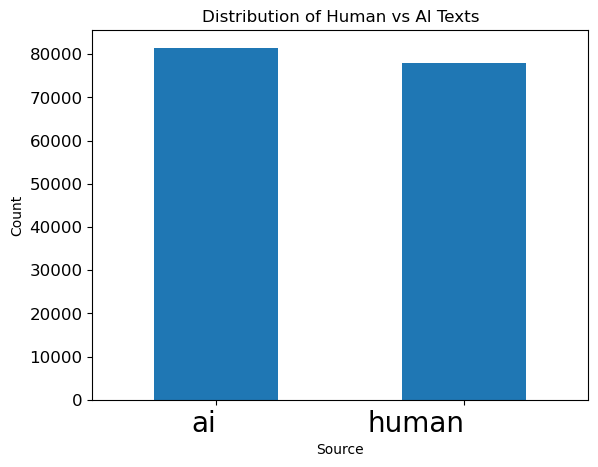

In [38]:
print(df_small["source"].value_counts())
df_small["source"].value_counts().plot(kind="bar")
plt.title("Distribution of Human vs AI Texts")
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(fontsize=20, rotation=0, ha="right")                # Bigger x-ticks, rotated for readability
plt.yticks(fontsize=12)    
plt.show()

In [39]:
df_small["text_length"] = df_small["text"].str.len()

print("text length by source: ",df_small.groupby("source")["text_length"].mean())

text length by source:  source
ai       378.560318
human    399.418375
Name: text_length, dtype: float64


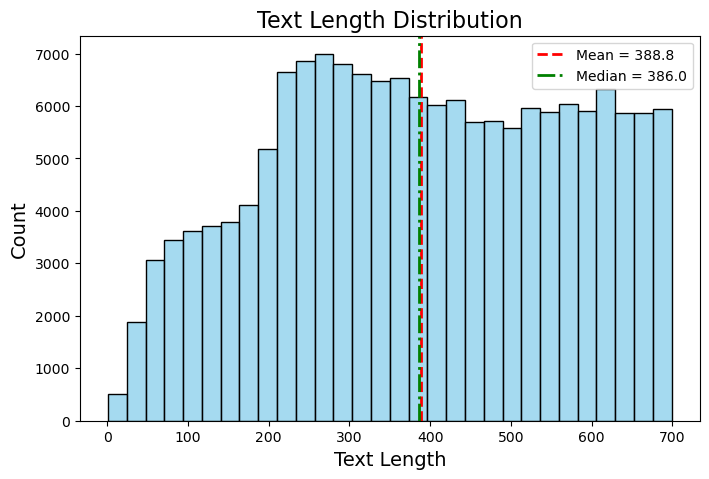

In [40]:
plt.figure(figsize=(8,5))

# Plot a single histogram (no separation by source)
sns.histplot(df_small["text_length"], bins=30, kde=False, color="skyblue")

# Calculate stats
mean_val = df_small["text_length"].mean()
median_val = df_small["text_length"].median()

# Add lines
plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.1f}")
plt.axvline(median_val, color="green", linestyle="-.", linewidth=2, label=f"Median = {median_val:.1f}")

# Titles & labels
plt.title("Text Length Distribution", fontsize=16)
plt.xlabel("Text Length", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend()

plt.show()


In [41]:
def count_sentences(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    # Split by ., !, ? followed by space or end of string
    sentences = re.split(r'[.!?]+(?:\s|$)', text.strip())
    # Remove empty strings
    sentences = [s for s in sentences if s]
    return len(sentences)

df_small["sentence_count"] = df_small["text"].apply(count_sentences)

print(df_small.groupby("source")["sentence_count"].mean())

source
ai       4.041990
human    4.625415
Name: sentence_count, dtype: float64


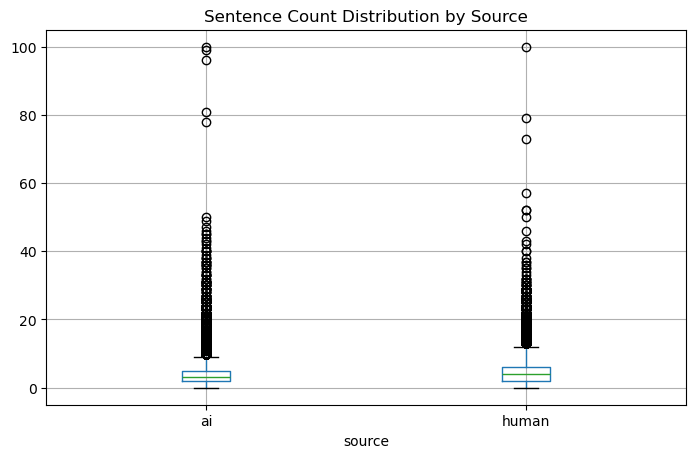

In [42]:
df_small.boxplot(column="sentence_count", by="source", figsize=(8,5))
plt.title("Sentence Count Distribution by Source")
plt.suptitle("")
plt.show()

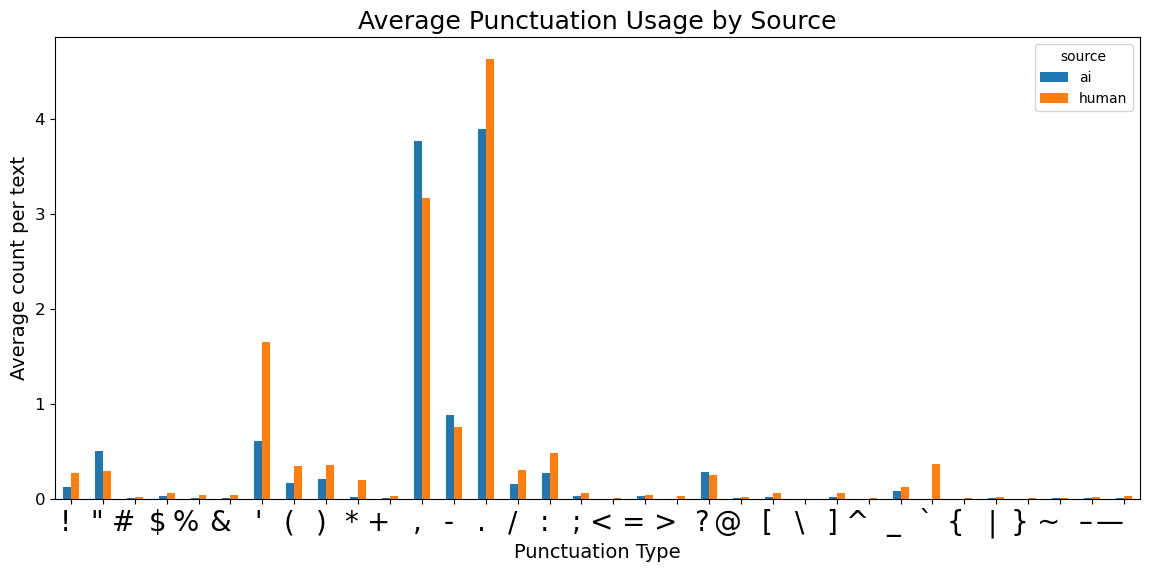

In [43]:
import string
import re
import matplotlib.pyplot as plt

# Define punctuation characters (add em dash and en dash)
punctuations = string.punctuation + "–—"  # en dash (–) and em dash (—)

# Count occurrences of each punctuation in every text
for p in punctuations:
    # Create safe column names by replacing unusual symbols with readable names
    safe_p = p
    if p == "–":
        safe_p = "endash"
    elif p == "—":
        safe_p = "emdash"
    df_small[f"count_{safe_p}"] = df_small["text"].str.count(re.escape(p))

# Compute averages by source
punct_avg = (
    df_small.groupby("source")[
        [col for col in df_small.columns if col.startswith("count_")]
    ]
    .mean()
    .T
)
punct_avg.index = (
    punct_avg.index.str.replace("count_", "", regex=False)
    .str.replace("endash", "–", regex=False)
    .str.replace("emdash", "—", regex=False)
)

# Plot
punct_avg.plot(kind="bar", figsize=(14, 6))

plt.title("Average Punctuation Usage by Source", fontsize=18)
plt.ylabel("Average count per text", fontsize=14)
plt.xlabel("Punctuation Type", fontsize=14)
plt.xticks(fontsize=20, rotation=0, ha="right")
plt.yticks(fontsize=12)

plt.show()


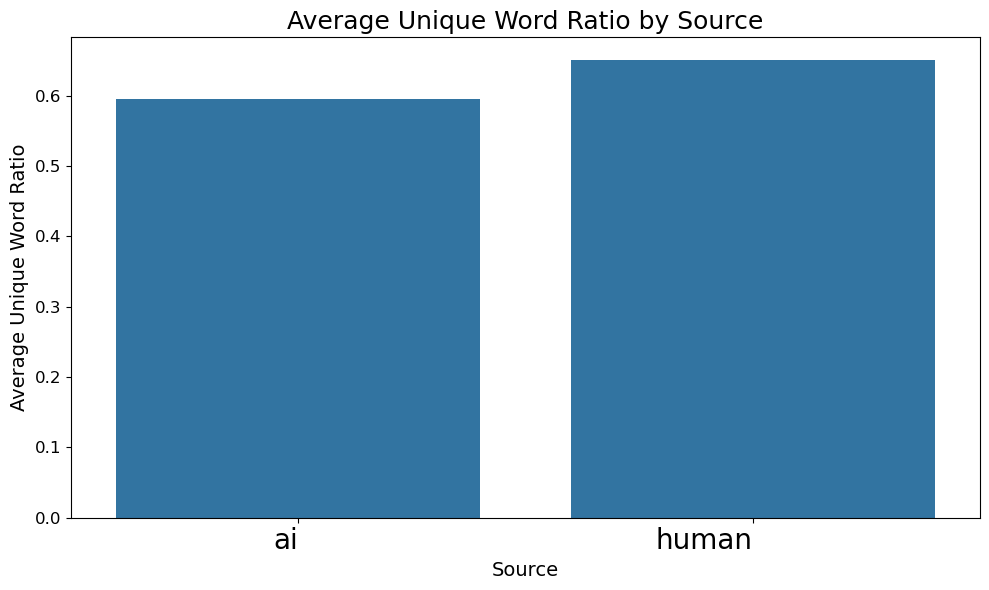

In [44]:

import seaborn as sns
import matplotlib.pyplot as plt

# Convert the Series to a DataFrame and reset the index
avg_unique_ratio = avg_unique_ratio.reset_index()

# Rename columns for clarity
avg_unique_ratio.columns = ["source", "avg_unique_ratio"]

# Plot with seaborn
plt.figure(figsize=(10,6))
sns.barplot(data=avg_unique_ratio, x="source", y="avg_unique_ratio")

plt.title("Average Unique Word Ratio by Source", fontsize=18)
plt.xlabel("Source", fontsize=14)
plt.ylabel("Average Unique Word Ratio", fontsize=14)

plt.xticks(fontsize=20, rotation=0, ha="right")
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


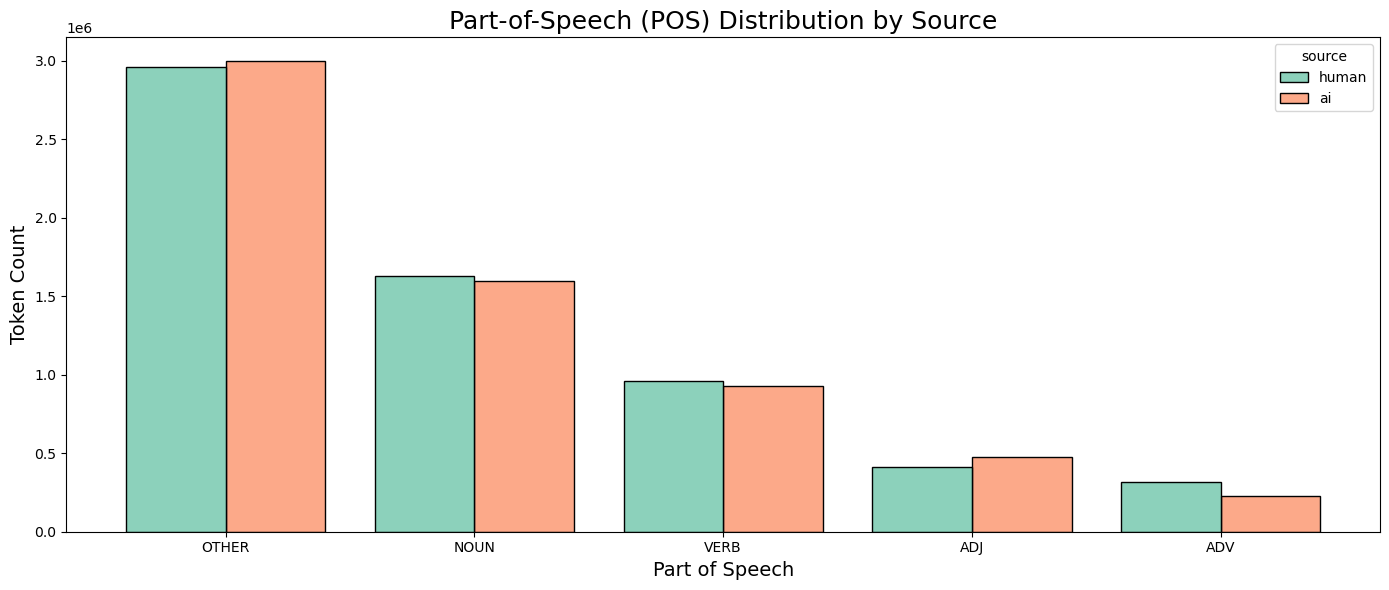

In [45]:


# --- POS Tagging Function ---
def get_pos_groups(text, source):
    if not isinstance(text, str):  # Skip or handle NaN/non-string
        return []
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)
    pos_data = []
    for _, pos in tags:
        if pos.startswith("N"):
            pos_data.append({"source": source, "pos": "NOUN"})
        elif pos.startswith("V"):
            pos_data.append({"source": source, "pos": "VERB"})
        elif pos.startswith("J"):
            pos_data.append({"source": source, "pos": "ADJ"})
        elif pos.startswith("R"):
            pos_data.append({"source": source, "pos": "ADV"})
        else:
            pos_data.append({"source": source, "pos": "OTHER"})
    return pos_data
# --- Apply to your DataFrame ---
pos_records = []
for _, row in df_small.iterrows():
    pos_records.extend(get_pos_groups(row["text"], row["source"]))

pos_df = pd.DataFrame(pos_records)

plt.figure(figsize=(14, 6))
sns.histplot(data=pos_df, x="pos", hue="source", multiple="dodge", shrink=0.8, palette="Set2")
plt.title("Part-of-Speech (POS) Distribution by Source", fontsize=18)
plt.xlabel("Part of Speech", fontsize=14)
plt.ylabel("Token Count", fontsize=14)
plt.tight_layout()
plt.show()


C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_1172\2688842303.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


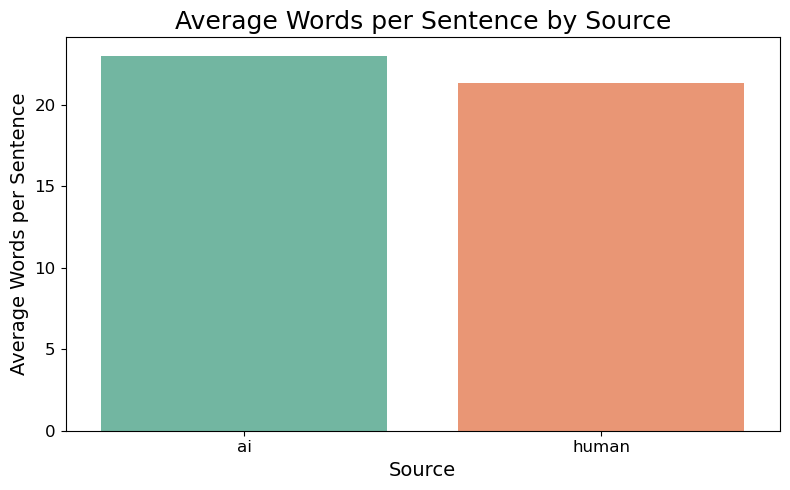

In [46]:
def avg_words_per_sentence(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    sentences = sent_tokenize(text)
    if not sentences:
        return 0
    word_counts = [len(word_tokenize(s)) for s in sentences]
    return sum(word_counts) / len(sentences)

# --- Compute average words per sentence for each text ---
df_small["avg_words_per_sentence"] = df_small["text"].apply(avg_words_per_sentence)

# --- Aggregate by source (e.g. "human" vs "ai") ---
avg_stats = df_small.groupby("source")["avg_words_per_sentence"].mean().reset_index()

# --- Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(
    data=avg_stats,
    x="source",
    y="avg_words_per_sentence",
    palette="Set2",
    errorbar=None
)

plt.title("Average Words per Sentence by Source", fontsize=18)
plt.xlabel("Source", fontsize=14)
plt.ylabel("Average Words per Sentence", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

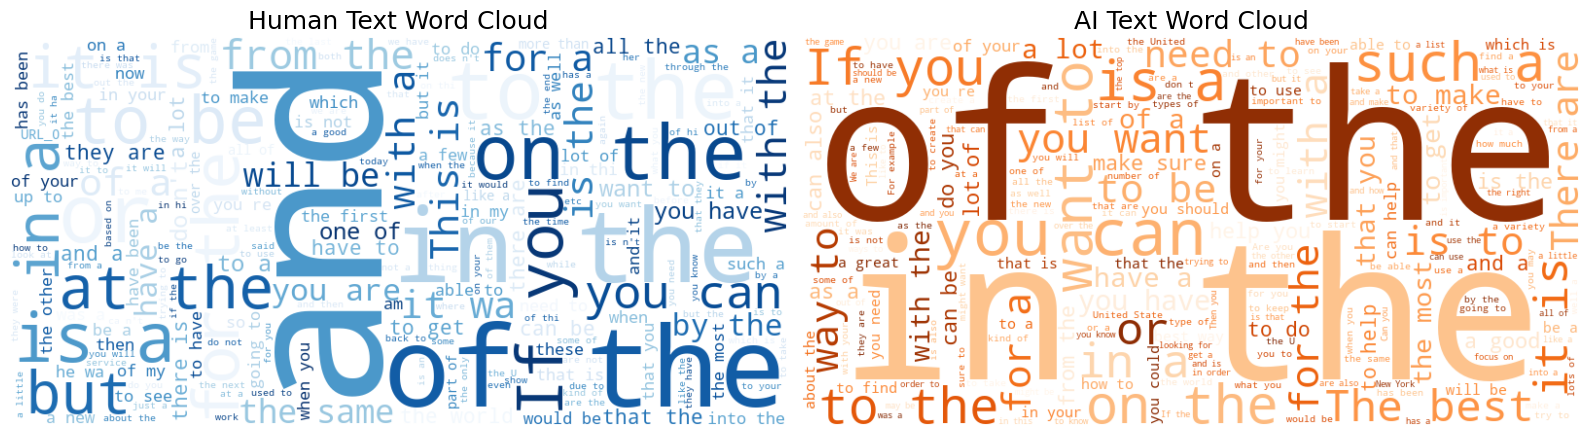

In [47]:
human_text = " ".join(df_small.loc[df_small["source"].str.lower() == "human", "text"].dropna().astype(str))
ai_text    = " ".join(df_small.loc[df_small["source"].str.lower() == "ai", "text"].dropna().astype(str))

# --- Create word clouds ---
human_wc = WordCloud(width=800, height=400, background_color="white", colormap="Blues", stopwords="english").generate(human_text)
ai_wc    = WordCloud(width=800, height=400, background_color="white", colormap="Oranges", stopwords="english").generate(ai_text)

# --- Plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(human_wc, interpolation="bilinear")
axes[0].set_title("Human Text Word Cloud", fontsize=18)
axes[0].axis("off")

axes[1].imshow(ai_wc, interpolation="bilinear")
axes[1].set_title("AI Text Word Cloud", fontsize=18)
axes[1].axis("off")

plt.tight_layout()
plt.show()

# embeddings

In [ ]:
#tf idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Copy the data
df_small_copy = df_small.copy()
df_small_copy = df_small_copy.dropna(subset=['text']).reset_index(drop=True)
df_small_copy['text'] = df_small_copy['text'].astype(str)

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, token_pattern=r'\b[a-zA-Z]{2,}\b')

# Fit + transform (returns sparse matrix)
tfidf_matrix = vectorizer.fit_transform(df_small_copy['text'])

tfidf_sample = pd.DataFrame(
    tfidf_matrix[:5].toarray(),
    columns=vectorizer.get_feature_names_out()
)

# Show the first 5 rows
tfidf_sample.head()

,abilities,ability,able,about,above,absolute,absolutely,absorb,abstract,abuse,...,yours,yourself,youth,youtube,zealand,zero,zip,zipper,zombie,zone
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.071035,0.0,0.0,0.162415,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.069557,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.182683,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [ ]:
#tf idf
print('test')

In [ ]:
#bag of words
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer (BoW)
vectorizer = CountVectorizer(max_features=5000, token_pattern=r'\b[a-zA-Z]{2,}\b')


# Fit + transform the text data
bow_matrix = vectorizer.fit_transform(df_small_copy['text'])

# inspect a small sample
sample_bow = pd.DataFrame(
    bow_matrix[:5].toarray(),
    columns=vectorizer.get_feature_names_out()
)
sample_bow.head()

,abilities,ability,able,about,above,absolute,absolutely,absorb,abstract,abuse,...,yours,yourself,youth,youtube,zealand,zero,zip,zipper,zombie,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
#bag of words

In [52]:
from gensim.models import Word2Vec


In [53]:
#word2vec

def preprocess_text(s):
    s = str(s).lower()
    s = re.sub(r'\s+', ' ', s)                 # collapse whitespace
    s = re.sub(r'http\S+|www\.\S+', '', s)     # remove URLs
    s = re.sub(r'@\w+', '', s)                 # remove mentions
    s = re.sub(r'[^a-z0-9\s]', ' ', s)         # keep alphanum only
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df_small['text_clean'] = df_small['text'].apply(preprocess_text)
# tokenize to lists of words
df_small['tokens'] = df_small['text_clean'].apply(word_tokenize)

In [54]:
#word2vec

# sentences = list of token lists
sentences = df_small['tokens'].tolist()

w2v_params = {
    'sentences': sentences,
    'vector_size': 100,   # embedding dimension (try 100 or 300)
    'window': 5,
    'min_count': 2,       # words with freq <2 ignored; lower if small dataset
    'workers': 4,
    'sg': 1,              # 1 = skip-gram, 0 = CBOW
    'epochs': 10
}

w2v_model = Word2Vec(**w2v_params)

# Save model for later
w2v_model.save("word2vec_small_df.model")
# Save keyed vectors (smaller)
w2v_model.wv.save_word2vec_format("word2vec_small_df.bin", binary=True)


In [55]:

dim = w2v_model.vector_size

def doc_vector_avg(tokens):
    vecs = []
    for t in tokens:
        if t in w2v_model.wv:
            vecs.append(w2v_model.wv[t])
    if len(vecs) == 0:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

df_small['w2v_doc_embed'] = df_small['tokens'].apply(doc_vector_avg).tolist()


In [56]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("danielwillgeorge/glove6b100dtxt")

print("Path to dataset files:", path)

ModuleNotFoundError: No module named 'kagglehub'

In [ ]:
#glove

def load_glove(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.rstrip().split(' ')
            word = parts[0]
            vec = np.asarray(parts[1:], dtype='float32')
            embeddings[word] = vec
    return embeddings

glove_path = 'glove.6B.100d.txt'  # whichever file you downloaded
glove_emb = load_glove(glove_path)
glove_dim = len(next(iter(glove_emb.values())))

In [ ]:
#glove

def glove_doc_avg(tokens):
    vecs = [glove_emb[t] for t in tokens if t in glove_emb]
    if not vecs: return np.zeros(glove_dim)
    return np.mean(vecs, axis=0)

df_small['glove_doc_embed'] = df_small['tokens'].apply(glove_doc_avg).tolist()